## Package imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = list(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import data

In [3]:
data = pd.read_parquet('./input/dataframes/df_val.parquet')
data.head(10)

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,11/18/2015,FHA mortgage,"Loan modification,collection,foreclosure",None,I bought a house in XXXX XXXX in XXXX. It was ...,Company chooses not to provide a public response,Bank of America,CA,935XX,None,Consent provided,Web,11/18/2015,Closed with explanation,Yes,No,1662008
1,09/03/2015,Home equity loan or line of credit,"Application, originator, mortgage broker",None,XX/XX/XXXX my husband and I took an equity lin...,Company chooses not to provide a public response,Bank of America,PA,189XX,None,Consent provided,Web,09/03/2015,Closed with explanation,Yes,No,1551463
2,07/12/2015,Medical,Cont'd attempts collect debt not owed,Debt is not mine,"Dear sir/madam, I want ESCALLATE to remove the...",Company chooses not to provide a public response,"Escallate, LLC",IL,604XX,None,Consent provided,Web,07/12/2015,Closed,Yes,Yes,1463692
3,07/03/2015,"Other (i.e. phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,I had XXXX Alliance One Accounts on my credit ...,None,AllianceOne Recievables Management,WA,981XX,None,Consent provided,Web,07/03/2015,Closed with explanation,Yes,No,1451082
4,12/10/2015,Credit card,Communication tactics,Frequent or repeated calls,Portfolio Recovery continues to contact me and...,None,"Portfolio Recovery Associates, Inc.",MD,214XX,None,Consent provided,Web,12/10/2015,Closed with non-monetary relief,Yes,No,1691577
5,08/28/2015,Vehicle loan,Taking out the loan or lease,None,"From my experience with DriveTime, there was a...",Company chooses not to provide a public response,DriveTime,NC,282XX,None,Consent provided,Web,08/28/2015,Closed with explanation,Yes,Yes,1541730
6,08/12/2015,Other mortgage,"Loan modification,collection,foreclosure",None,An Affidavit of Truth Final Opportunity To Cur...,Company chooses not to provide a public response,Specialized Loan Servicing LLC,MD,207XX,Servicemember,Consent provided,Web,08/12/2015,Closed with explanation,Yes,No,1516435
7,04/06/2016,None,Late fee,None,We used a Home Depot credit card with a 6 mont...,Company has responded to the consumer and the ...,Citibank,MN,566XX,None,Consent provided,Web,04/06/2016,Closed with monetary relief,Yes,No,1867949
8,09/04/2015,Payday loan,Can't stop charges to bank account,Can't stop charges to bank account,"I took out a loan from this company, just afte...",Company believes it acted appropriately as aut...,"Bliksum, LLC",SC,297XX,None,Consent provided,Web,09/08/2015,Closed with explanation,Yes,No,1552107
9,03/03/2016,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"In 2010, I declared bankruptcy. My mortgage wi...",Company has responded to the consumer and the ...,Wells Fargo & Company,CA,954XX,None,Consent provided,Web,03/03/2016,Closed with explanation,Yes,Yes,1812417


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 14029 non-null  object
 1   sub_product                   9734 non-null   object
 2   issue                         14029 non-null  object
 3   sub_issue                     6916 non-null   object
 4   consumer_complaint_narrative  14029 non-null  object
 5   company_public_response       6879 non-null   object
 6   company                       14029 non-null  object
 7   state                         13993 non-null  object
 8   zipcode                       13993 non-null  object
 9   tags                          2427 non-null   object
 10  consumer_consent_provided     14029 non-null  object
 11  submitted_via                 14029 non-null  object
 12  date_sent_to_company          14029 non-null  object
 13  company_response

In [5]:
df_val = data.copy()

In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 14029 non-null  object
 1   sub_product                   9734 non-null   object
 2   issue                         14029 non-null  object
 3   sub_issue                     6916 non-null   object
 4   consumer_complaint_narrative  14029 non-null  object
 5   company_public_response       6879 non-null   object
 6   company                       14029 non-null  object
 7   state                         13993 non-null  object
 8   zipcode                       13993 non-null  object
 9   tags                          2427 non-null   object
 10  consumer_consent_provided     14029 non-null  object
 11  submitted_via                 14029 non-null  object
 12  date_sent_to_company          14029 non-null  object
 13  company_response

In [7]:
df_val.shape

(14029, 17)

## Drop univariate and unneeded variables

In [8]:
df_val = df_val.drop(['consumer_consent_provided', 'submitted_via', 'complaint_id'], axis=1)

In [9]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 14029 non-null  object
 1   sub_product                   9734 non-null   object
 2   issue                         14029 non-null  object
 3   sub_issue                     6916 non-null   object
 4   consumer_complaint_narrative  14029 non-null  object
 5   company_public_response       6879 non-null   object
 6   company                       14029 non-null  object
 7   state                         13993 non-null  object
 8   zipcode                       13993 non-null  object
 9   tags                          2427 non-null   object
 10  date_sent_to_company          14029 non-null  object
 11  company_response_to_consumer  14029 non-null  object
 12  timely_response               14029 non-null  object
 13  consumer_dispute

In [10]:
df_val.head(3)

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,11/18/2015,FHA mortgage,"Loan modification,collection,foreclosure",None,I bought a house in XXXX XXXX in XXXX. It was ...,Company chooses not to provide a public response,Bank of America,CA,935XX,None,11/18/2015,Closed with explanation,Yes,No
1,09/03/2015,Home equity loan or line of credit,"Application, originator, mortgage broker",None,XX/XX/XXXX my husband and I took an equity lin...,Company chooses not to provide a public response,Bank of America,PA,189XX,None,09/03/2015,Closed with explanation,Yes,No
2,07/12/2015,Medical,Cont'd attempts collect debt not owed,Debt is not mine,"Dear sir/madam, I want ESCALLATE to remove the...",Company chooses not to provide a public response,"Escallate, LLC",IL,604XX,None,07/12/2015,Closed,Yes,Yes


## Explore target value and transform with LabelEncoder

In [11]:
y_val = pd.read_parquet('./input/y_targets/y_val.parquet')
y_val.head()

,product
0,Mortgage
1,Mortgage
2,Debt collection
3,Debt collection
4,Debt collection


In [12]:
product = y_val['product'].value_counts()
print(product)

Debt collection            3686
Mortgage                   3133
Credit reporting           2630
Credit card                1665
Bank account or service    1199
Consumer Loan               772
Student loan                447
Prepaid card                181
Payday loan                 153
Money transfers             140
Other financial service      23
Name: product, dtype: int64


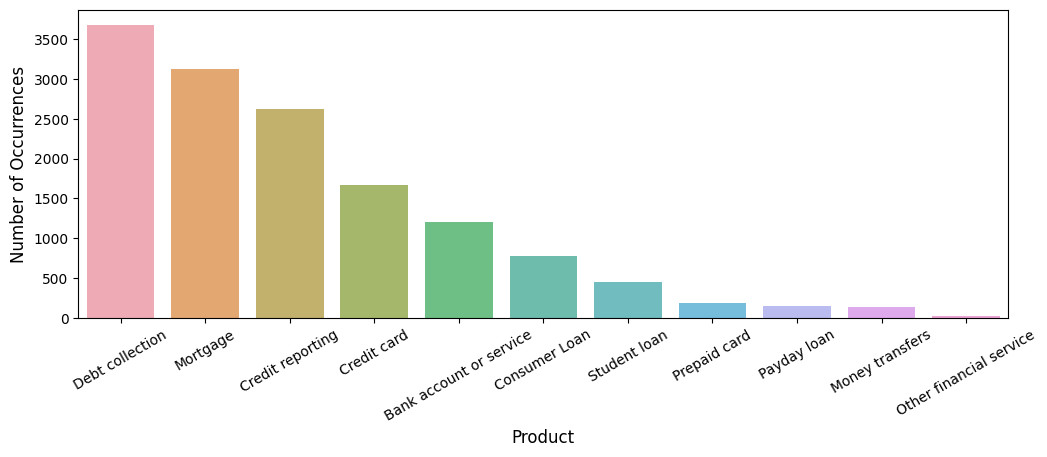

In [13]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [14]:
y_val['label'] = LabelEncoder().fit_transform(y_val['product'])

In [15]:
y_val_LE = y_val.drop(['product'], axis=1)

In [16]:
y_val_LE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   14029 non-null  int32
dtypes: int32(1)
memory usage: 54.9 KB


In [17]:
# Save label-encoded target labels
y_val_LE.to_parquet('./input/y_targets/y_val_LE.parquet')

In [18]:
# Drop original and label-encoded target dataframes from memory to mitigate potential data leakage
y_list = [y_val, y_val_LE]
del y_val, y_val_LE
del y_list

## Convert date values with datetime and create new feature for time between date_received and date_sent_to_company 

In [19]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_val['date_received'] = np.where(
    pd.isna(df_val['date_received']) == False,
    pd.to_datetime(df_val['date_received'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [20]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_val['date_sent_to_company'] = np.where(
    pd.isna(df_val['date_sent_to_company']) == False,
    pd.to_datetime(df_val['date_sent_to_company'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [21]:
# Create new feature that is the difference in days between when a complaint was received and when it was sent to company
df_val['days_between_receipt_and_sent'] = np.where(
    (pd.isna(df_val['date_received']) == False) & (pd.isna(df_val['date_sent_to_company']) == False),
    (df_val['date_sent_to_company'] - df_val['date_received']).dt.days,
    None
)

In [22]:
# Change new feature from datetime object to integer
df_val['days_between_receipt_and_sent'] = pd.to_numeric(df_val['days_between_receipt_and_sent'])

## Frequency encode 'sub_product' variable and add flag variables for missing/low-occurring

In [23]:
sub_product_freq = df_val.groupby('sub_product').size() / len(df_val)

In [24]:
# Vectorized operation to frequency encode sub_product category
df_val['sub_product_freq'] = np.where(
    pd.isna(df_val['sub_product']) == False,
    df_val['sub_product'].map(sub_product_freq),
    -1
)

In [25]:
# Vectorized operation to create binary flag variable for missing sub_product
df_val['sub_product_null_flag'] = np.where(
    pd.isna(df_val['sub_product']) == True,
    1,
    0
)

In [26]:
# Vectorized operation to create binary flag variable for low-occuring sub_product
df_val['sub_product_low_flag'] = np.where(
    (df_val['sub_product_freq'] <= 0.01) & (pd.isna(df_val['sub_product']) == False),
    1,
    0
)

## Frequency encode 'issue' variable and add flag variable for low-occurring

In [27]:
issue_freq = df_val.groupby('issue').size() / len(df_val)

In [28]:
# Vectorized operation to frequency encode issue category
df_val['issue_freq'] = np.where(
    pd.isna(df_val['issue']) == False,
    df_val['issue'].map(issue_freq),
    -1
)

In [29]:
# Vectorized operation to create binary flag variable for low-occuring issue
df_val['issue_low_flag'] = np.where(
    (df_val['issue_freq'] <= 0.01) & (pd.isna(df_val['issue']) == False),
    1,
    0
)

## Frequency encode 'sub_issue' variable and add flag variables for missing/low-occurring

In [30]:
sub_issue_freq = df_val.groupby('sub_issue').size() / len(df_val)

In [31]:
# Vectorized operation to frequency encode sub_issue category
df_val['sub_issue_freq'] = np.where(
    pd.isna(df_val['sub_issue']) == False,
    df_val['sub_issue'].map(sub_issue_freq),
    -1
)

In [32]:
# Vectorized operation to create binary flag variable for missing sub_issue
df_val['sub_issue_null_flag'] = np.where(
    pd.isna(df_val['sub_issue']) == True,
    1,
    0
)

In [33]:
# Vectorized operation to create binary flag variable for low-occuring sub_issue
df_val['sub_issue_low_flag'] = np.where(
    (df_val['sub_issue_freq'] <= 0.01) & (pd.isna(df_val['sub_issue']) == False),
    1,
    0
)

## Frequency encode 'company_public_response' variable and add flag variables for missing/low-occurring

In [34]:
company_public_response_freq = df_val.groupby('company_public_response').size() / len(df_val)

In [35]:
# Vectorized operation to frequency encode company_public_response category
df_val['company_public_response_freq'] = np.where(
    pd.isna(df_val['company_public_response']) == False,
    df_val['company_public_response'].map(company_public_response_freq),
    -1
)

In [36]:
# Vectorized operation to create binary flag variable for missing company_public_response
df_val['company_public_response_null_flag'] = np.where(
    pd.isna(df_val['company_public_response']) == True,
    1,
    0
)

In [37]:
# Vectorized operation to create binary flag variable for low-occuring company_public_response
df_val['company_public_response_low_flag'] = np.where(
    (df_val['company_public_response_freq'] <= 0.01) & (pd.isna(df_val['company_public_response']) == False),
    1,
    0
)

## Frequency encode 'company' variable and add flag variable for low-occurring

In [38]:
company_freq = df_val.groupby('company').size() / len(df_val)

In [39]:
# Vectorized operation to frequency encode company category
df_val['company_freq'] = np.where(
    pd.isna(df_val['company']) == False,
    df_val['company'].map(company_freq),
    -1
)

In [40]:
# Vectorized operation to create binary flag variable for low-occuring company
df_val['company_low_flag'] = np.where(
    (df_val['company_freq'] <= 0.01) & (pd.isna(df_val['company']) == False),
    1,
    0
)

## Frequency encode 'state' variable and add flag variables for missing/low-occurring

In [41]:
state_freq = df_val.groupby('state').size() / len(df_val)

In [42]:
# Vectorized operation to frequency encode state category
df_val['state_freq'] = np.where(
    pd.isna(df_val['state']) == False,
    df_val['state'].map(state_freq),
    -1
)

In [43]:
# Vectorized operation to create binary flag variable for missing state
df_val['state_null_flag'] = np.where(
    pd.isna(df_val['state']) == True,
    1,
    0
)

In [44]:
# Vectorized operation to create binary flag variable for low-occuring state
df_val['state_low_flag'] = np.where(
    (df_val['state_freq'] <= 0.01) & (pd.isna(df_val['state']) == False),
    1,
    0
)

## Frequency encode 'zipcode' variable and add flag variables for missing/low-occurring

In [45]:
zipcode_freq = df_val.groupby('zipcode').size() / len(df_val)

In [46]:
# Vectorized operation to frequency encode zipcode category
df_val['zipcode_freq'] = np.where(
    pd.isna(df_val['zipcode']) == False,
    df_val['zipcode'].map(zipcode_freq),
    -1
)

In [47]:
# Vectorized operation to create binary flag variable for missing zipcode
df_val['zipcode_null_flag'] = np.where(
    pd.isna(df_val['zipcode']) == True,
    1,
    0
)

In [48]:
# Vectorized operation to create binary flag variable for low-occuring zipcode
df_val['zipcode_low_flag'] = np.where(
    (df_val['zipcode_freq'] <= 0.001) & (pd.isna(df_val['zipcode']) == False), # change from 0.01 to 0.001 since zips are all fairly low-occurring
    1,
    0
)

## One-hot encode 'tags' variable but change nulls to "Not Older American, Not Servicemember" first

In [49]:
df_val['tags'].fillna("Not Older American, Not Servicemember", inplace=True)

In [50]:
df_val['tags'].value_counts()

Not Older American, Not Servicemember    11602
Older American                            1278
Servicemember                              964
Older American, Servicemember              185
Name: tags, dtype: int64

In [51]:
OH_encoder = OneHotEncoder(dtype='int')
tags_df_val = pd.DataFrame(OH_encoder.fit_transform(df_val[['tags']]).toarray(), columns=OH_encoder.categories_[0])

In [52]:
tags_df_val.head()

,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [53]:
df_val = df_val.join(tags_df_val)

## One-hot encode 'company_response_to_consumer' variable

In [54]:
df_val['company_response_to_consumer'].value_counts()

Closed with explanation            10727
Closed with non-monetary relief     1768
Closed with monetary relief         1062
Closed                               357
Untimely response                    115
Name: company_response_to_consumer, dtype: int64

In [55]:
response_df_val = pd.DataFrame(OH_encoder.fit_transform(df_val[['company_response_to_consumer']]).toarray(), 
                    columns=OH_encoder.categories_[0])

In [56]:
response_df_val.head()

,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,0,1,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,0,1,0


In [57]:
df_val = df_val.join(response_df_val)

## Binary encode 'timely_response' variable

In [58]:
df_val['timely_response'].value_counts()

Yes    13591
No       438
Name: timely_response, dtype: int64

In [59]:
# Vectorized operation to create binary flag variable for timely_response
df_val['timely_response'] = np.where(
    df_val['timely_response'].str.contains('Yes'),
    1,
    0
)

In [60]:
df_val['timely_response'].value_counts()

1    13591
0      438
Name: timely_response, dtype: int64

## Binary encode 'consumer_disputed?' variable

In [61]:
df_val['consumer_disputed?'].value_counts()

No     10728
Yes     3301
Name: consumer_disputed?, dtype: int64

In [62]:
# Vectorized operation to create binary flag variable for consumer_disputed?
df_val['consumer_disputed?'] = np.where(
    df_val['consumer_disputed?'].str.contains('Yes'), 
    1,
    0
)

In [63]:
df_val['consumer_disputed?'].value_counts()

0    10728
1     3301
Name: consumer_disputed?, dtype: int64

In [64]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date_received                          14029 non-null  object 
 1   sub_product                            9734 non-null   object 
 2   issue                                  14029 non-null  object 
 3   sub_issue                              6916 non-null   object 
 4   consumer_complaint_narrative           14029 non-null  object 
 5   company_public_response                6879 non-null   object 
 6   company                                14029 non-null  object 
 7   state                                  13993 non-null  object 
 8   zipcode                                13993 non-null  object 
 9   tags                                   14029 non-null  object 
 10  date_sent_to_company                   14029 non-null  object 
 11  co

In [65]:
df_val.head()

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,2015-11-18,FHA mortgage,"Loan modification,collection,foreclosure",None,I bought a house in XXXX XXXX in XXXX. It was ...,Company chooses not to provide a public response,Bank of America,CA,935XX,"Not Older American, Not Servicemember",2015-11-18,Closed with explanation,1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0
1,2015-09-03,Home equity loan or line of credit,"Application, originator, mortgage broker",None,XX/XX/XXXX my husband and I took an equity lin...,Company chooses not to provide a public response,Bank of America,PA,189XX,"Not Older American, Not Servicemember",2015-09-03,Closed with explanation,1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0
2,2015-07-12,Medical,Cont'd attempts collect debt not owed,Debt is not mine,"Dear sir/madam, I want ESCALLATE to remove the...",Company chooses not to provide a public response,"Escallate, LLC",IL,604XX,"Not Older American, Not Servicemember",2015-07-12,Closed,1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0
3,2015-07-03,"Other (i.e. phone, health club, etc.)",False statements or representation,Attempted to collect wrong amount,I had XXXX Alliance One Accounts on my credit ...,None,AllianceOne Recievables Management,WA,981XX,"Not Older American, Not Servicemember",2015-07-03,Closed with explanation,1,0,0,0.077625,0,0,0.024449,0,0.017963,0,0,-1.000000,1,0,0.000998,1,0.022168,0,0,0.003707,0,0,1,0,0,0,0,1,0,0,0
4,2015-12-10,Credit card,Communication tactics,Frequent or repeated calls,Portfolio Recovery continues to contact me and...,None,"Portfolio Recovery Associates, Inc.",MD,214XX,"Not Older American, Not Servicemember",2015-12-10,Closed with non-monetary relief,1,0,0,0.052890,0,0,0.039775,0,0.023024,0,0,-1.000000,1,0,0.010692,0,0.031150,0,0,0.000356,0,1,1,0,0,0,0,0,0,1,0


## Drop non-converted and unneeded columns to keep feature-engineered dataframe

In [66]:
# keep 'product' bc used LabelEncoder here but have used cat.code factorization previously
df_val_fe = df_val.drop(['date_received', 'sub_product', 'issue', 'sub_issue', 'company_public_response', 'company', 
                         'state', 'zipcode', 'tags', 'date_sent_to_company', 'company_response_to_consumer'], axis=1)

In [67]:
df_val_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           14029 non-null  object 
 1   timely_response                        14029 non-null  int32  
 2   consumer_disputed?                     14029 non-null  int32  
 3   days_between_receipt_and_sent          14029 non-null  int64  
 4   sub_product_freq                       14029 non-null  float64
 5   sub_product_null_flag                  14029 non-null  int32  
 6   sub_product_low_flag                   14029 non-null  int32  
 7   issue_freq                             14029 non-null  float64
 8   issue_low_flag                         14029 non-null  int32  
 9   sub_issue_freq                         14029 non-null  float64
 10  sub_issue_null_flag                    14029 non-null  int32  
 11  su

In [68]:
df_val_fe.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,I bought a house in XXXX XXXX in XXXX. It was ...,1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0
1,XX/XX/XXXX my husband and I took an equity lin...,1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0
2,"Dear sir/madam, I want ESCALLATE to remove the...",1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0
3,I had XXXX Alliance One Accounts on my credit ...,1,0,0,0.077625,0,0,0.024449,0,0.017963,0,0,-1.000000,1,0,0.000998,1,0.022168,0,0,0.003707,0,0,1,0,0,0,0,1,0,0,0
4,Portfolio Recovery continues to contact me and...,1,0,0,0.052890,0,0,0.039775,0,0.023024,0,0,-1.000000,1,0,0.010692,0,0.031150,0,0,0.000356,0,1,1,0,0,0,0,0,0,1,0


## Save munged and feature-engineered dataframe for modeling

In [69]:
df_val_fe.to_parquet('./input/dataframes/df_val_FE.parquet')

## NLP for validation set text

### Functions for cleaning and processing text

In [70]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

In [71]:
#L = WordNetLemmatizer()
s = SnowballStemmer('english')

def wordPreProcess(sentence):
    return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [72]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names_out()

## View and prepare text

In [73]:
for i in df_val_fe['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

I bought a house in XXXX XXXX in XXXX. It was my primary residence. I fixed it up and made the payments regularly until about XXXX XXXX at which point I called the bank to see what options were available. I explained that I was unable to make the payments any longer, that my parents were sick and that I had put the house on the market in XXXX and moved to XXXX. I gave them all the information they requested. Since then they have continually bounced me from one representative to another almost like a shell game. They did this until the information was outdated and I had to submit all new information such as my XXXX tax statements, bank statements, recent pay stubs, and an explanation why I was unable to make the payments. They would then tell me via mail that I do n't meet investor guidelines. I talked to HUD and they tell me I do! The bank assigns me another representative and we go through the whole procedure again. By now we are 9 months into this process doing this hide and seek and

In [74]:
df_val_fe = df_val_fe.rename({'consumer_complaint_narrative':'text'},axis=1)

In [75]:
df_val_fe['text'] = df_val_fe['text'].astype(str)

In [76]:
df_val_fe.head()

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,I bought a house in XXXX XXXX in XXXX. It was ...,1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0
1,XX/XX/XXXX my husband and I took an equity lin...,1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0
2,"Dear sir/madam, I want ESCALLATE to remove the...",1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0
3,I had XXXX Alliance One Accounts on my credit ...,1,0,0,0.077625,0,0,0.024449,0,0.017963,0,0,-1.000000,1,0,0.000998,1,0.022168,0,0,0.003707,0,0,1,0,0,0,0,1,0,0,0
4,Portfolio Recovery continues to contact me and...,1,0,0,0.052890,0,0,0.039775,0,0.023024,0,0,-1.000000,1,0,0.010692,0,0.031150,0,0,0.000356,0,1,1,0,0,0,0,0,0,1,0


## Sanitize and vectorize text

In [77]:
df_val_fe = clean_text(df_val_fe)

In [78]:
X_text_val, feat_text_val = getTextFeatures(df_val_fe, 'text')

processing:  text


c:\Miniconda\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [79]:
print(X_text_val)

  (0, 4710)	0.11901348241088842
  (0, 3734)	0.09496522126245066
  (0, 4215)	0.13759088100182015
  (0, 494)	0.1331153434095287
  (0, 1813)	0.12665539061278241
  (0, 2203)	0.1173014400480093
  (0, 2922)	0.11148593672133963
  (0, 4133)	0.13567926719926995
  (0, 4885)	0.07591622167677124
  (0, 2234)	0.11055289573699688
  (0, 1555)	0.12498302534336446
  (0, 3976)	0.12110462091060747
  (0, 4379)	0.1260823012191667
  (0, 4562)	0.13271816678323495
  (0, 3023)	0.10148753668648987
  (0, 1558)	0.1331153434095287
  (0, 495)	0.10764805556599635
  (0, 4878)	0.1297956593446717
  (0, 2082)	0.09472715598433801
  (0, 2074)	0.12045407423294362
  (0, 1792)	0.13861965851258362
  (0, 4706)	0.12200620029759125
  (0, 2602)	0.1169400471318385
  (0, 4770)	0.1380986743067163
  (0, 266)	0.1331153434095287
  :	:
  (14028, 2530)	0.05303003238292442
  (14028, 4330)	0.054272834585252
  (14028, 3686)	0.04734766918206801
  (14028, 200)	0.046851281721583884
  (14028, 4012)	0.05575365157755121
  (14028, 1)	0.063576228256

In [80]:
#Saving the validation text features into an NPZ file
sparse.save_npz("./input/X_matrices/X_text_val.npz", X_text_val)

## Combine text matrix with engineered features from EDA

In [81]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'days_between_receipt_and_sent',
              'sub_product_freq', 'sub_product_null_flag', 'sub_product_low_flag', 'issue_freq',
              'issue_low_flag', 'sub_issue_freq','sub_issue_null_flag', 'sub_issue_low_flag',
              'company_public_response_freq', 'company_public_response_null_flag', 'company_public_response_low_flag',
              'company_freq', 'company_low_flag', 'state_freq', 'state_null_flag', 'state_low_flag',
              'zipcode_freq', 'zipcode_null_flag', 'zipcode_low_flag', 'Not Older American, Not Servicemember',
              'Older American', 'Older American, Servicemember', 'Servicemember', 'Closed', 'Closed with explanation',
              'Closed with monetary relief', 'Closed with non-monetary relief', 'Untimely response']

In [82]:
X_val = hstack((X_text_val, StandardScaler().fit_transform(df_val_fe[numFeatures]))).tocsr()

In [83]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/X_val.npz", X_val)